# StableOpt and GP-UCB for Toy Synthetic Toy Example in Chapter 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy.optimize import Bounds
import scipy.spatial.distance as spdist
import time
%matplotlib inline

In [2]:
# define f_toy
def f(w):
    '''
    w should be an array of size N*1 or N (1-D)
    
    '''
    w_vec=w.flatten()
    x,y=w_vec
    return -2*x**6+12.2*x**5-21.2*x**4-6.2*x+6.4*x**3+4.7*x**2-y**6+11*y**5-43.3*y**4+10*y+74.8*y**3-56.9*y**2+4.1*x*y+0.1*y**2*x**2-0.4*y**2*x-0.4*x**2*y

In [3]:
# define function of g_toy, as shown in report
def g(w):
    
    w_vec=w.flatten()
    
    x,y=w_vec
    
    ineq_cons = {'type': 'ineq','fun' : lambda x: 0.50-np.linalg.norm(x)}
    
    def k(theta):
        if np.linalg.norm(theta)<=0.5 and -0.95<=w[0]-theta[0]<=3.2 and -0.45<=w[1]-theta[1]<=4.4:
            return f(w-theta)
        else:
            return np.inf

        
    #opt=scipy.optimize.shgo(lambda theta: k(theta),bounds=[(-0.5,0.5), (-0.5,0.5)],n=700,iters=6)
    opt=scipy.optimize.differential_evolution(lambda theta: k(theta),bounds=[(-0.5,0.5), (-0.5,0.5)])
    #opt=scipy.optimize.dual_annealing(lambda theta: k(theta),bounds=[(-0.5,0.5), (-0.5,0.5)])
    return opt.fun


In [4]:
# define bounds of the optimisation and also find the worst-case robust solution of the 
bounds=((-0.95, 3.2), (-0.45, 4.4))
opt=scipy.optimize.shgo(lambda w:-g(w), bounds,n=750,iters=7) 
max_w=opt.x
max_fun=-opt.fun

C:\Users\win\anaconda\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [29]:
# The noisy sampling function from the f_toy.
def noisy_f(w):
    return f(w)+np.random.normal(0,0.1)

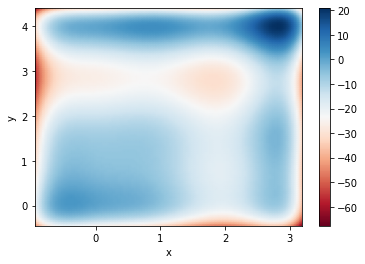

In [63]:
# Plot of f_toy
x_ori = np.linspace(-0.95, 3.2, 100)
y_ori = np.linspace(-0.45, 4.4, 100)

X_ori, Y_ori = np.meshgrid(x_ori, y_ori)

Z_ori=np.zeros((100,100))

for i in range(100):
    for j in range(100):
        Z_ori[i,j]=f(np.array([X_ori[i,j],Y_ori[i,j]]))
        
plot = plt.pcolormesh(X_ori, Y_ori, Z_ori, cmap='RdBu', shading='gouraud')
plt.colorbar(plot)
plt.xlabel('x')
plt.ylabel("y")
plt.savefig('synthetic_example_original.pdf')

C:\Users\win\anaconda\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


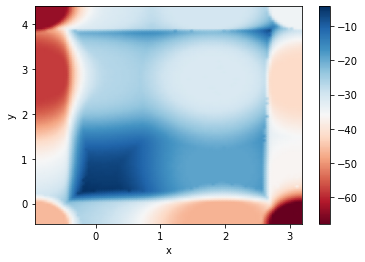

In [64]:
# Plot of g_toy, as defined in report.
x_pert = np.linspace(-0.95, 3.2, 100)
y_pert = np.linspace(-0.45, 4.4, 100)

X_pert, Y_pert = np.meshgrid(x_pert, y_pert)

Z_pert=np.zeros((100,100))

for i in range(100):
    for j in range(100):
        Z_pert[i,j]=g(np.array([X_pert[i,j],Y_pert[i,j]]))
        
plot = plt.pcolormesh(X_pert, Y_pert, Z_pert, cmap='RdBu', shading='gouraud')
plt.colorbar(plot)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('synthetic_example_pertubed.pdf')

In [6]:
# define the function of ARD SE Kernel
def covSEard(hyp=None, x=None, z=None):
    ''' Squared Exponential covariance function with Automatic Relevance Detemination
     (ARD) distance measure. The covariance function is parameterized as:
    
     k(x^p,x^q) = sf2 * exp(-(x^p - x^q)' * inv(P) * (x^p - x^q)/2)
    
     where the P matrix is diagonal with ARD parameters ell_1^2,...,ell_D^2, where
     D is the dimension of the input space and sf2 is the signal variance.
    
     The hyperparameters are:
    
     hyp = [ log(ell_1)
             log(ell_2)
             ...
             log(ell_D)
             log(sqrt(sf2)) ], which is an 1-D list.
             x should be an n*D matrix
             z should be a list, for example [[1,2],[3,4]]
    '''
    
    if hyp == None:                 
        return ['D + 1']            
    
    [n, D] = x.shape
    ell = 1/np.exp(hyp[0:D])        

    sf2 = np.exp(2.*hyp[D])         

    if z == 'diag':
        A = np.zeros((n,1))
    elif z == None:
        tmp = np.dot(np.diag(ell),x.T).T
        A = spdist.cdist(tmp, tmp, 'sqeuclidean')
    else:                           # compute covariance between data sets x and z
        A = spdist.cdist(np.dot(np.diag(ell),x.T).T, np.dot(np.diag(ell),np.asarray(z).T).T, 'sqeuclidean') # cross covariances
 
    A = sf2*np.exp(-0.5*A)
                
    return A

In [7]:
# Sampling 50 data where the function values are bigger than -15.0, for training hyperparameter.
np.random.seed(41)
points = []
num_points=50
index = 0
while index < num_points:
    x=np.random.uniform(-0.95,3.2)
    y=np.random.uniform(-0.45,4.4)
    w=np.array([x,y])
    if f(w)>-15.0:
        points = points + [[x,y]]
        index = index + 1   

sample_points=np.asarray(points)
sample_funval=np.asarray([f(x) for x in sample_points]).reshape(50,1)

In [8]:
# Obtain hyperparameters in of ARD SE Kernel via maximum likelihood of marginal GP log likelihood
def logmarli(x):
    '''
    x is a list of hyperparameters consists of [ell_1 ... ell_D, sqrt(sf2)] 
    and must be positive.
    
    '''
    log_x=np.log(x)
    par=log_x.tolist()
    K=covSEard(par,sample_points)
    K_t=K
    neg_log_marginal_likelihood=0.5*np.dot(np.dot(sample_funval.T,np.linalg.inv(K_t)),sample_funval)+0.5*np.log(np.linalg.det(K_t))+25*np.log(2*np.pi)
    
    return neg_log_marginal_likelihood[0,0]

ard=scipy.optimize.minimize(lambda w:logmarli(w), np.array([1.4,1.0,2.3]),method="L-BFGS-B",options = {'disp':True}) #optimized value of ell_1, ell_2 and sqrt(sf2)
ard_param=np.log(ard.x).tolist()

In [30]:
# Sample 10 intial points from noisy_f and fixed these points
np.random.seed(29)
initial_points=[]
initial_funval=[]
for i in range(10):
    x_noise=np.random.uniform(-0.95,3.2)
    y_noise=np.random.uniform(-0.45,4.4)
    initial_points=initial_points+[[x_noise,y_noise]]
    initial_funval=initial_funval+[noisy_f(np.array([x_noise,y_noise]))]

In [31]:
# change the data type of these points
train_points=np.asarray(initial_points)
train_funval=np.asarray(initial_funval).reshape(10,1)

# Set the observation noise and the beta parameter in the first experiment
noise=0.01
beta_sqrt=2

# Define mean function, variance function, lcb, ucb of GP model
def mu(x,input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    n,D=input_data_x.shape
    x_list=x.reshape(1,2).tolist()
    K_t=covSEard(ard_param,input_data_x)+noise*np.identity(n)
    mean=np.dot(np.dot(covSEard(ard_param,input_data_x,x_list).T,np.linalg.inv(K_t)),input_data_y)
    
    return mean[0,0]

def sigma_sq(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    n,D=input_data_x.shape
    x_vec=x.reshape(1,2)
    x_list=x_vec.tolist()
    K_t=covSEard(ard_param,input_data_x)+noise*np.identity(n)
    var=covSEard(ard_param,x_vec,x_list)-np.dot(np.dot(covSEard(ard_param,input_data_x,x_list).T,np.linalg.inv(K_t)),covSEard(ard_param,input_data_x,x_list))
    return var[0,0]

def ucb(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    ucb=mu(x,input_data_x, input_data_y)+beta_sqrt*np.sqrt(sigma_sq(x, input_data_x, input_data_y))
    return ucb

def lcb(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    lcb=mu(x,input_data_x, input_data_y)-beta_sqrt*np.sqrt(sigma_sq(x, input_data_x, input_data_y))
    return lcb

In [32]:
def stable_opt(train_points,train_funval, T):
    regret=[] #value of regret in each iteration
    returned_points=[] # returned points in all iterations
    #T=80 #number of iteration

    for t in range(T):
    
        def ucb_min(x):
        
            def k(theta):
                if np.linalg.norm(theta)<=0.5 and -0.95<=x[0]-theta[0]<=3.2 and -0.45<=x[1]-theta[1]<=4.4:
                    return ucb(x-theta,train_points,train_funval)
                else:
                    return np.inf
        
            opt=scipy.optimize.differential_evolution(lambda theta: k(theta),bounds=[(-0.5,0.5), (-0.5,0.5)])
        
            return opt.fun
        
        max_ucb=scipy.optimize.shgo(lambda w:-ucb_min(w), bounds,n=500, iters=5)
    
        x_bar_t=max_ucb.x
    
        def lcb_perturbed(theta):
        
            if np.linalg.norm(theta)<=0.5 and -0.95<=x_bar_t[0]-theta[0]<=3.2 and -0.45<=x_bar_t[1]-theta[1]<=4.4:
                return lcb(x_bar_t-theta,train_points,train_funval)
            else:
                return np.inf
        
    
        min_lcb=scipy.optimize.differential_evolution(lambda theta: lcb_perturbed(theta),bounds=[(-0.5,0.5), (-0.5,0.5)])
    
        theta_t=min_lcb.x
    
        y_t=noisy_f(x_bar_t-theta_t)
    
        train_points=np.row_stack([train_points,x_bar_t-theta_t])
    
        train_funval=np.row_stack([train_funval,y_t])
    
        r_t=max_fun-g(x_bar_t)
    
        regret=regret+[r_t]
    
        returned_points=returned_points+[x_bar_t]
        
    return regret, returned_points

In [34]:
# first experiment of StableOpt with beta_sqrt=2:
regret_experiment=[]
returned_points_experiment=[]

for i in range(2):
    regret_single,returned_points_single=stable_opt(np.asarray(initial_points),np.asarray(initial_funval).reshape(10,1), 60)
    regret_experiment=regret_experiment+[regret_single]
    returned_points_experiment=returned_points_experiment+[returned_points_single]

C:\Users\win\anaconda\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\win\anaconda\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


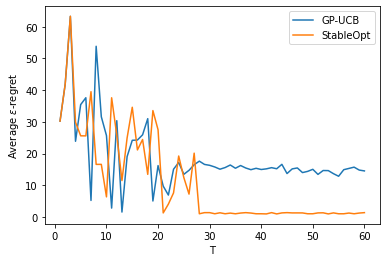

In [41]:
# Now implement GP-UCB method in 1st experiment
noise=0.01
beta_sqrt=2
# define mean function, variance function, lcb, ucb of GP model
def mu(x,input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    n,D=input_data_x.shape
    x_list=x.reshape(1,2).tolist()
    K_t=covSEard(ard_param,input_data_x)+noise*np.identity(n)
    mean=np.dot(np.dot(covSEard(ard_param,input_data_x,x_list).T,np.linalg.inv(K_t)),input_data_y)
    
    return mean[0,0]

def sigma_sq(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    n,D=input_data_x.shape
    x_vec=x.reshape(1,2)
    x_list=x_vec.tolist()
    K_t=covSEard(ard_param,input_data_x)+noise*np.identity(n)
    var=covSEard(ard_param,x_vec,x_list)-np.dot(np.dot(covSEard(ard_param,input_data_x,x_list).T,np.linalg.inv(K_t)),covSEard(ard_param,input_data_x,x_list))
    return var[0,0]

def ucb(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    ucb=mu(x,input_data_x, input_data_y)+beta_sqrt*np.sqrt(sigma_sq(x, input_data_x, input_data_y))
    return ucb

def lcb(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    lcb=mu(x,input_data_x, input_data_y)-beta_sqrt*np.sqrt(sigma_sq(x, input_data_x, input_data_y))
    return lcb

def GP_UCB(train_points,train_funval, T):
    regret=[] #value of regret in each iteration
    returned_points=[] # returned points in all iterations
    run_time=[] #with the calculation of running time in each iteration

    for t in range(T):
        start = time.time()
        
        def ucb_fixed(w):
            
            return ucb(w,train_points,train_funval)
        
        max_ucb=scipy.optimize.shgo(lambda w:-ucb_fixed(w), bounds,n=500, iters=5)
    
        x_bar_t=max_ucb.x
    
        y_t=noisy_f(x_bar_t)
    
        train_points=np.row_stack([train_points,x_bar_t])
    
        train_funval=np.row_stack([train_funval,y_t])
    
        r_t=max_fun-g(x_bar_t)
    
        regret=regret+[r_t]
    
        returned_points=returned_points+[x_bar_t]
        
        stop = time.time()
        
        duration = stop-start
        
        run_time=run_time+[duration]
        
    return regret, returned_points, run_time

# first experiment with GP-UCB:
regret_experiment_1_GP_UCB=[]
returned_points_experiment_1_GP_UCB=[]
run_time_experiment_1_GP_UCB=[]

for i in range(2):
    regret_single,returned_points_single,run_time_single=GP_UCB(np.asarray(initial_points),np.asarray(initial_funval).reshape(10,1), 60)
    regret_experiment_1_GP_UCB=regret_experiment_1_GP_UCB+[regret_single]
    returned_points_experiment_1_GP_UCB=returned_points_experiment_1_GP_UCB+[returned_points_single]
    run_time_experiment_1_GP_UCB=run_time_experiment_1_GP_UCB+[run_time_single]

# Plot the result of the first experiment with both StableOpt and GP-UCB
plt.plot(range(1,61),np.mean(regret_experiment_1_GP_UCB,axis=0),label="GP-UCB")
plt.plot(range(1,61),np.mean(regret_experiment,axis=0),label="StableOpt")
plt.xlabel('T')
plt.ylabel(r'Average $\epsilon $-regret')
plt.legend()
plt.savefig('first_experiment_toy_example_ard_beta_2_GP_UCB.pdf')
plt.show()

In [42]:
# Change the Beta_sqrt of the experiment to be 1.5
noise=0.01
beta_sqrt=1.5
# second experiment with StableOpt and beta_sqrt=1.5:
regret_experiment_2=[]
returned_points_experiment_2=[]

for i in range(2):
    regret_single,returned_points_single=stable_opt(np.asarray(initial_points),np.asarray(initial_funval).reshape(10,1), 60)
    regret_experiment_2=regret_experiment_2+[regret_single]
    returned_points_experiment_2=returned_points_experiment_2+[returned_points_single]
    

C:\Users\win\anaconda\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\win\anaconda\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


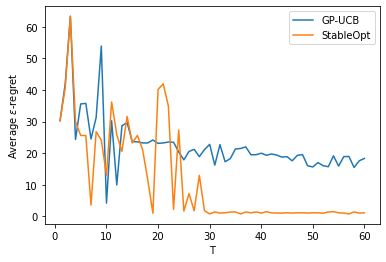

In [43]:
# Now implement GP-UCB methods in 2nd experiment
noise=0.01
beta_sqrt=1.
# GP-UCB for second experiment
regret_experiment_2_GP_UCB=[]
returned_points_experiment_2_GP_UCB=[]
run_time_experiment_2_GP_UCB=[]

for i in range(2):
    regret_single,returned_points_single,run_time_single=GP_UCB(np.asarray(initial_points),np.asarray(initial_funval).reshape(10,1), 60)
    regret_experiment_2_GP_UCB=regret_experiment_2_GP_UCB+[regret_single]
    returned_points_experiment_2_GP_UCB=returned_points_experiment_2_GP_UCB+[returned_points_single]
    run_time_experiment_2_GP_UCB=run_time_experiment_2_GP_UCB+[run_time_single]

# Plot the results of the second experiment with both StableOpt and GP-UCB
plt.plot(range(1,61),np.mean(regret_experiment_2_GP_UCB,axis=0),label="GP-UCB")
plt.plot(range(1,61),np.mean(regret_experiment_2,axis=0),label="StableOpt")
plt.xlabel('T')
plt.ylabel(r'Average $\epsilon $-regret')
plt.legend()
plt.savefig('second_experiment_toy_example_ard_beta_1.5_GP_UCB.pdf')
plt.show()

In [44]:
# Change the Beta_sqrt of the experiment to be 3
noise=0.01
beta_sqrt=3

# third experiment with StableOpt and beta_sqrt=3:
regret_experiment_3=[]
returned_points_experiment_3=[]

for i in range(2):
    regret_single,returned_points_single=stable_opt(np.asarray(initial_points),np.asarray(initial_funval).reshape(10,1), 60)
    regret_experiment_3=regret_experiment_3+[regret_single]
    returned_points_experiment_3=returned_points_experiment_3+[returned_points_single]

C:\Users\win\anaconda\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\win\anaconda\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


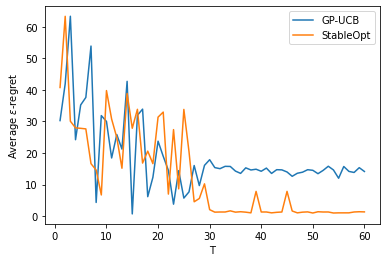

In [45]:
# Now implement GP-UCB methods in the third experiment
noise=0.01
beta_sqrt=3

#GP-UCB for the third experiment:
regret_experiment_3_GP_UCB=[]
returned_points_experiment_3_GP_UCB=[]
run_time_experiment_3_GP_UCB=[]

for i in range(2):
    regret_single,returned_points_single,run_time_single=GP_UCB(np.asarray(initial_points),np.asarray(initial_funval).reshape(10,1), 60)
    regret_experiment_3_GP_UCB=regret_experiment_3_GP_UCB+[regret_single]
    returned_points_experiment_3_GP_UCB=returned_points_experiment_3_GP_UCB+[returned_points_single]
    run_time_experiment_3_GP_UCB=run_time_experiment_3_GP_UCB+[run_time_single]

# Plot of the results of both StableOpt and GP-UCB for the third experiment.
plt.plot(range(1,61),np.mean(regret_experiment_3_GP_UCB,axis=0),label="GP-UCB")
plt.plot(range(1,61),np.mean(regret_experiment_3,axis=0),label="StableOpt")
plt.xlabel('T')
plt.ylabel(r'Average $\epsilon $-regret')
plt.legend()
plt.savefig('third_experiment_toy_example_ard_beta_3_GP_UCB.pdf')
plt.show()

In [46]:
# Change the Beta_sqrt of the experiment to be 1 and change the stable_opt function to include 
# the running time of each iteration
noise=0.01
beta_sqrt=1

#fourth experiment of StableOpt with beta_sqrt=1:
regret_experiment_4=[]
returned_points_experiment_4=[]
run_time_experiment_4=[]

for i in range(2):
    regret_single,returned_points_single,run_time_single=stable_opt(np.asarray(initial_points),np.asarray(initial_funval).reshape(10,1), 60)
    regret_experiment_4=regret_experiment_4+[regret_single]
    returned_points_experiment_4=returned_points_experiment_4+[returned_points_single]
    run_time_experiment_4=run_time_experiment_4+[run_time_single]


C:\Users\win\anaconda\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\win\anaconda\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


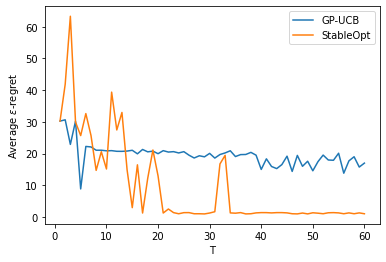

In [47]:
# Now implement GP-UCB methods in the fourth experiment
noise=0.01
beta_sqrt=1

#fourth experiment for GP-UCB:
regret_experiment_4_GP_UCB=[]
returned_points_experiment_4_GP_UCB=[]
run_time_experiment_4_GP_UCB=[]

for i in range(2):
    regret_single,returned_points_single,run_time_single=GP_UCB(np.asarray(initial_points),np.asarray(initial_funval).reshape(10,1), 60)
    regret_experiment_4_GP_UCB=regret_experiment_4_GP_UCB+[regret_single]
    returned_points_experiment_4_GP_UCB=returned_points_experiment_4_GP_UCB+[returned_points_single]
    run_time_experiment_4_GP_UCB=run_time_experiment_4_GP_UCB+[run_time_single]

# Plot the results of StableOpt and GP-UCB for the fourth experiment.
plt.plot(range(1,61),np.mean(regret_experiment_4_GP_UCB,axis=0),label="GP-UCB")
plt.plot(range(1,61),np.mean(regret_experiment_4,axis=0),label="StableOpt")
plt.xlabel('T')
plt.ylabel(r'Average $\epsilon $-regret')
plt.legend()
plt.savefig('fourth_experiment_toy_example_ard_beta_1_GP_UCB.pdf')
plt.show()

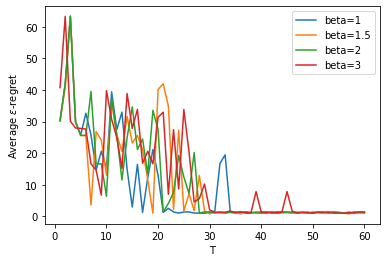

In [49]:
# Make a comparison of the regret of the 4 experiments
plt.plot(range(1,61),np.mean(regret_experiment_4,axis=0),label="beta=1")
plt.plot(range(1,61),np.mean(regret_experiment_2,axis=0),label="beta=1.5")
plt.plot(range(1,61),np.mean(regret_experiment,axis=0),label="beta=2")
plt.plot(range(1,61),np.mean(regret_experiment_3,axis=0),label="beta=3")
plt.xlabel('T')
plt.ylabel(r'Average $\epsilon $-regret')
plt.legend()
plt.savefig('Comparison_of_the_four_experiment.pdf')
plt.show()

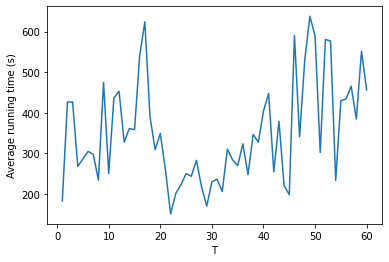

In [80]:
# Plot the running time for the fourth experiment of the StableOpt above with sigma^2=0.01.
plt.plot(range(1,61),np.mean(run_time_experiment_4,axis=0))
plt.xlabel('T')
plt.ylabel('Average running time (s)')
plt.savefig('fourth_experiment_toy_example_ard_beta_1_running_time.pdf')
plt.show()

In [67]:
# what if the noise of the data is higher? would there be any difference in the performance? change the noise from 0.01 to 1.
def noisy_f_new(w):
    return f(w)+np.random.normal(0,1)

# Sample 10 intial points from noisy_f_new and fixed these points
np.random.seed(29)
initial_points_new=[]
initial_funval_new=[]
for i in range(10):
    x_noise_new=np.random.uniform(-0.95,3.2)
    y_noise_new=np.random.uniform(-0.45,4.4)
    initial_points_new=initial_points_new+[[x_noise_new,y_noise_new]]
    initial_funval_new=initial_funval_new+[noisy_f_new(np.array([x_noise_new,y_noise_new]))]

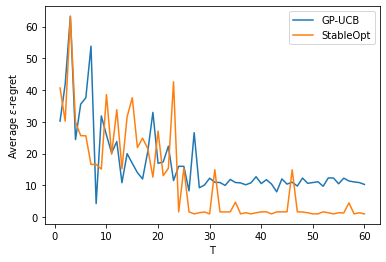

In [75]:
# set the observation noise to be 1 and the beta parameter to be 2, as in experiment 1 above
noise=1
beta_sqrt=2
# define mean function, variance function, lcb, ucb of GP model
def mu(x,input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    n,D=input_data_x.shape
    x_list=x.reshape(1,2).tolist()
    K_t=covSEard(ard_param,input_data_x)+noise*np.identity(n)
    mean=np.dot(np.dot(covSEard(ard_param,input_data_x,x_list).T,np.linalg.inv(K_t)),input_data_y)
    
    return mean[0,0]

def sigma_sq(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    n,D=input_data_x.shape
    x_vec=x.reshape(1,2)
    x_list=x_vec.tolist()
    K_t=covSEard(ard_param,input_data_x)+noise*np.identity(n)
    var=covSEard(ard_param,x_vec,x_list)-np.dot(np.dot(covSEard(ard_param,input_data_x,x_list).T,np.linalg.inv(K_t)),covSEard(ard_param,input_data_x,x_list))
    return var[0,0]

def ucb(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    ucb=mu(x,input_data_x, input_data_y)+beta_sqrt*np.sqrt(sigma_sq(x, input_data_x, input_data_y))
    return ucb

def lcb(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    lcb=mu(x,input_data_x, input_data_y)-beta_sqrt*np.sqrt(sigma_sq(x, input_data_x, input_data_y))
    return lcb

def stable_opt(train_points,train_funval, T):
    regret=[] #value of regret in each iteration
    returned_points=[] # returned points in all iterations
    #T=80 #number of iteration

    for t in range(T):
    
        def ucb_min(x):
        
            def k(theta):
                if np.linalg.norm(theta)<=0.5 and -0.95<=x[0]-theta[0]<=3.2 and -0.45<=x[1]-theta[1]<=4.4:
                    return ucb(x-theta,train_points,train_funval)
                else:
                    return np.inf
        
            opt=scipy.optimize.differential_evolution(lambda theta: k(theta),bounds=[(-0.5,0.5), (-0.5,0.5)])
        
            return opt.fun
        
        max_ucb=scipy.optimize.shgo(lambda w:-ucb_min(w), bounds,n=500, iters=5)
    
        x_bar_t=max_ucb.x
    
        def lcb_perturbed(theta):
        
            if np.linalg.norm(theta)<=0.5 and -0.95<=x_bar_t[0]-theta[0]<=3.2 and -0.45<=x_bar_t[1]-theta[1]<=4.4:
                return lcb(x_bar_t-theta,train_points,train_funval)
            else:
                return np.inf
        
    
        min_lcb=scipy.optimize.differential_evolution(lambda theta: lcb_perturbed(theta),bounds=[(-0.5,0.5), (-0.5,0.5)])
    
        theta_t=min_lcb.x
    
        y_t=noisy_f_new(x_bar_t-theta_t)
    
        train_points=np.row_stack([train_points,x_bar_t-theta_t])
    
        train_funval=np.row_stack([train_funval,y_t])
    
        r_t=max_fun-g(x_bar_t)
    
        regret=regret+[r_t]
    
        returned_points=returned_points+[x_bar_t]
        
    return regret, returned_points

# Do StableOpt for another round of experiment with noise being 1 and beta_sqrt being 2
regret_experiment_new=[]
returned_points_experiment_new=[]

for i in range(2):
    regret_single_new,returned_points_single_new=stable_opt(np.asarray(initial_points_new),np.asarray(initial_funval_new).reshape(10,1), 60)
    regret_experiment_new=regret_experiment_new+[regret_single_new]
    returned_points_experiment_new=returned_points_experiment_new+[returned_points_single_new]
    
noise=1
beta_sqrt=2
# define mean function, variance function, lcb, ucb of GP model
def mu(x,input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    n,D=input_data_x.shape
    x_list=x.reshape(1,2).tolist()
    K_t=covSEard(ard_param,input_data_x)+noise*np.identity(n)
    mean=np.dot(np.dot(covSEard(ard_param,input_data_x,x_list).T,np.linalg.inv(K_t)),input_data_y)
    
    return mean[0,0]

def sigma_sq(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    n,D=input_data_x.shape
    x_vec=x.reshape(1,2)
    x_list=x_vec.tolist()
    K_t=covSEard(ard_param,input_data_x)+noise*np.identity(n)
    var=covSEard(ard_param,x_vec,x_list)-np.dot(np.dot(covSEard(ard_param,input_data_x,x_list).T,np.linalg.inv(K_t)),covSEard(ard_param,input_data_x,x_list))
    return var[0,0]

def ucb(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    ucb=mu(x,input_data_x, input_data_y)+beta_sqrt*np.sqrt(sigma_sq(x, input_data_x, input_data_y))
    return ucb

def lcb(x, input_data_x, input_data_y):
    '''
    x is the 1-Dimensional input vector of size D at any points within the domain and input_data_x is the 
    n*D x data set and input_y is the n*1 y value.
    
    '''
    lcb=mu(x,input_data_x, input_data_y)-beta_sqrt*np.sqrt(sigma_sq(x, input_data_x, input_data_y))
    return lcb

def GP_UCB(train_points,train_funval, T):
    regret=[] #value of regret in each iteration
    returned_points=[] # returned points in all iterations
    run_time=[] #with the calculation of running time in each iteration

    for t in range(T):
        start = time.time()
        
        def ucb_fixed(w):
            
            return ucb(w,train_points,train_funval)
        
        max_ucb=scipy.optimize.shgo(lambda w:-ucb_fixed(w), bounds,n=500, iters=5)
    
        x_bar_t=max_ucb.x
    
        y_t=noisy_f_new(x_bar_t)
    
        train_points=np.row_stack([train_points,x_bar_t])
    
        train_funval=np.row_stack([train_funval,y_t])
    
        r_t=max_fun-g(x_bar_t)
    
        regret=regret+[r_t]
    
        returned_points=returned_points+[x_bar_t]
        
        stop = time.time()
        
        duration = stop-start
        
        run_time=run_time+[duration]
        
    return regret, returned_points, run_time

# Do GP-UCB for another round of experiment with noise being 1 and beta_sqrt being 2
regret_experiment_1_GP_UCB_new=[]
returned_points_experiment_1_GP_UCB_new=[]

for i in range(2):
    regret_single_new,returned_points_single_new,run_time_single_new=GP_UCB(np.asarray(initial_points_new),np.asarray(initial_funval_new).reshape(10,1), 60)
    regret_experiment_1_GP_UCB_new=regret_experiment_1_GP_UCB_new+[regret_single_new]
    returned_points_experiment_1_GP_UCB_new=returned_points_experiment_1_GP_UCB_new+[returned_points_single_new]

# Plot the results of StableOpt and GP-UCB with noise being 1 and beta_sqrt being 2
plt.plot(range(1,61),np.mean(regret_experiment_1_GP_UCB_new,axis=0),label="GP-UCB")
plt.plot(range(1,61),np.mean(regret_experiment_new,axis=0),label="StableOpt")
plt.xlabel('T')
plt.ylabel(r'Average $\epsilon $-regret')
plt.legend()
plt.savefig('first_experiment_toy_example_ard_beta_2_GP_UCB_low_noise.pdf')
plt.show()

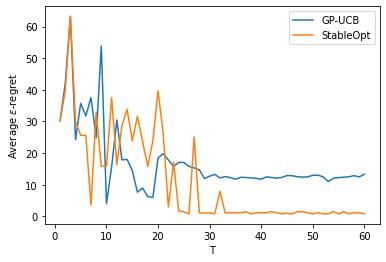

In [78]:
#  set the observation noise to be 1 and the beta parameter to be 1.5, as in experiment 2 above
noise=1
beta_sqrt=1.5

# Do StableOpt for another round of experiment with noise being 1 and beta_sqrt being 1.5
regret_experiment_2_new=[]
returned_points_experiment_2_new=[]

for i in range(2):
    regret_single_new,returned_points_single_new=stable_opt(np.asarray(initial_points_new),np.asarray(initial_funval_new).reshape(10,1), 60)
    regret_experiment_2_new=regret_experiment_2_new+[regret_single_new]
    returned_points_experiment_2_new=returned_points_experiment_2_new+[returned_points_single_new]

# Do GP-UCB for another round of experiment with noise being 1 and beta_sqrt being 1.5
regret_experiment_2_GP_UCB_new=[]
returned_points_experiment_2_GP_UCB_new=[]

for i in range(2):
    regret_single_new,returned_points_single_new,run_time_single_new=GP_UCB(np.asarray(initial_points_new),np.asarray(initial_funval_new).reshape(10,1), 60)
    regret_experiment_2_GP_UCB_new=regret_experiment_2_GP_UCB_new+[regret_single_new]
    returned_points_experiment_2_GP_UCB_new=returned_points_experiment_2_GP_UCB_new+[returned_points_single_new]

# Plot the results of StableOpt and GP-UCB with noise being 1 and beta_sqrt being 1.5
plt.plot(range(1,61),np.mean(regret_experiment_2_GP_UCB_new,axis=0),label="GP-UCB")
plt.plot(range(1,61),np.mean(regret_experiment_2_new,axis=0),label="StableOpt")
plt.xlabel('T')
plt.ylabel(r'Average $\epsilon $-regret')
plt.legend()
plt.savefig('second_experiment_toy_example_ard_beta_1.5_GP_UCB_low_noise.pdf')
plt.show()


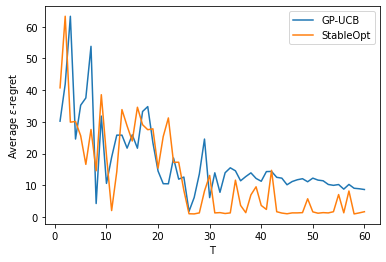

In [74]:
#  set the observation noise to be 1 and the beta parameter to be 3, as in experiment 3 above
noise=1
beta_sqrt=3

regret_experiment_3_new=[]
returned_points_experiment_3_new=[]

for i in range(2):
    regret_single_new,returned_points_single_new=stable_opt(np.asarray(initial_points_new),np.asarray(initial_funval_new).reshape(10,1), 60)
    regret_experiment_3_new=regret_experiment_3_new+[regret_single_new]
    returned_points_experiment_3_new=returned_points_experiment_3_new+[returned_points_single_new]

# Do GP-UCB for another round of experiment with noise being 1 and beta_sqrt being 3
regret_experiment_3_GP_UCB_new=[]
returned_points_experiment_3_GP_UCB_new=[]

for i in range(2):
    regret_single_new,returned_points_single_new,run_time_single_new=GP_UCB(np.asarray(initial_points_new),np.asarray(initial_funval_new).reshape(10,1), 60)
    regret_experiment_3_GP_UCB_new=regret_experiment_3_GP_UCB_new+[regret_single_new]
    returned_points_experiment_3_GP_UCB_new=returned_points_experiment_3_GP_UCB_new+[returned_points_single_new]

# Plot the results of StableOpt and GP-UCB with noise being 1 and beta_sqrt being 3
plt.plot(range(1,61),np.mean(regret_experiment_3_GP_UCB_new,axis=0),label="GP-UCB")
plt.plot(range(1,61),np.mean(regret_experiment_3_new,axis=0),label="StableOpt")
plt.xlabel('T')
plt.ylabel(r'Average $\epsilon $-regret')
plt.legend()
plt.savefig('third_experiment_toy_example_ard_beta_3_GP_UCB_low_noise.pdf')
plt.show()

C:\Users\win\anaconda\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


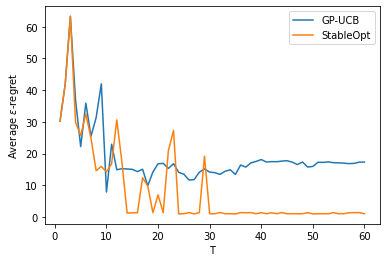

In [77]:
#  set the observation noise to be 1 and the beta parameter to be 1, as in experiment 4 above
noise=1
beta_sqrt=1

regret_experiment_4_new=[]
returned_points_experiment_4_new=[]

for i in range(2):
    regret_single_new,returned_points_single_new=stable_opt(np.asarray(initial_points_new),np.asarray(initial_funval_new).reshape(10,1), 60)
    regret_experiment_4_new=regret_experiment_4_new+[regret_single_new]
    returned_points_experiment_4_new=returned_points_experiment_4_new+[returned_points_single_new]

# Do GP-UCB for another round of experiment with noise being 1 and beta_sqrt being 1
regret_experiment_4_GP_UCB_new=[]
returned_points_experiment_4_GP_UCB_new=[]

for i in range(2):
    regret_single_new,returned_points_single_new,run_time_single_new=GP_UCB(np.asarray(initial_points_new),np.asarray(initial_funval_new).reshape(10,1), 60)
    regret_experiment_4_GP_UCB_new=regret_experiment_4_GP_UCB_new+[regret_single_new]
    returned_points_experiment_4_GP_UCB_new=returned_points_experiment_4_GP_UCB_new+[returned_points_single_new]

# Plot the results of StableOpt and GP-UCB with noise being 1 and beta_sqrt being 1
plt.plot(range(1,61),np.mean(regret_experiment_4_GP_UCB_new,axis=0),label="GP-UCB")
plt.plot(range(1,61),np.mean(regret_experiment_4_new,axis=0),label="StableOpt")
plt.xlabel('T')
plt.ylabel(r'Average $\epsilon $-regret')
plt.legend()
plt.savefig('fourth_experiment_toy_example_ard_beta_1_GP_UCB_low_noise.pdf')
plt.show()